In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# Load the dataset
dataset_path = 'C:/Users/hp/Downloads/GRP_dataset.xlsx'  
data = pd.read_excel(dataset_path)

# Initialize VADER sentiment intensity analyzer
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

# Define function to extract sentiment scores using VADER
def get_vader_sentiment(text):
    if pd.isnull(text):
        return 0  # Return a neutral score for missing text
    score = sia.polarity_scores(str(text))
    return score['compound']  # Use the compound score

# Apply VADER sentiment analysis to 'reviewText' and 'summary'
data['reviewText_sentiment'] = data['reviewText'].apply(get_vader_sentiment)
data['summary_sentiment'] = data['summary'].apply(get_vader_sentiment)

# Normalize 'overall_rating' and 'price'
scaler = StandardScaler()
data['normalized_rating'] = scaler.fit_transform(data[['overall_rating']])
data['price'] = data['price'].replace('[£$,]', '', regex=True).astype(float)  # Adjust regex for currency symbols
data['normalized_price'] = scaler.fit_transform(data[['price']])

# Encode 'verified' as numerical values
data['verified_numeric'] = data['verified'].astype(int)

# Combine features for clustering, now including 'verified_numeric'
features = data[['normalized_rating', 'normalized_price', 'reviewText_sentiment', 'summary_sentiment', 'verified_numeric']]

# Dimensionality Reduction with PCA
pca = PCA(n_components=2)  
features_pca = pca.fit_transform(features)

# Perform K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42).fit(features_pca)
data['cluster_label'] = kmeans.labels_

# Display the first few rows of the DataFrame to verify
data[['reviewText', 'summary', 'overall_rating', 'price', 'verified','cluster_label']].head()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,reviewText,summary,overall_rating,price,verified,cluster_label
0,they are gift cards,Five Stars,5,25.0,True,0
1,I ordered a bunch of gift cards and when the p...,You need to double check all gift cards!!!,2,25.0,True,2
2,Great,Five Stars,5,25.0,True,0
3,love getting 5% back buying giftcards when I u...,Five Stars,5,25.0,True,0
4,gift,Five Stars,5,25.0,True,0


In [ ]:
# Analyze average values in each cluster
cluster_analysis = data.groupby('cluster_label').mean()
cluster_analysis

,index_column,overall_rating,reviewTime,verified,price,reviewCount,reviewText_sentiment,summary_sentiment,normalized_rating,normalized_price,verified_numeric
cluster_label,,,,,,,,,,,
0,21998.918913,4.732239,2001.084007,0.877478,18.908282,279.805530,0.498360,0.287925,0.473023,-0.140994,0.877478
1,21204.020072,4.330466,2004.762007,0.810753,195.398516,191.477419,0.449366,0.210598,0.142215,4.393356,0.810753
2,25686.437103,2.148694,1999.027439,0.659336,19.291333,267.633814,0.091097,0.019938,-1.654191,-0.131153,0.659336


In [ ]:
# Calculate the mean sentiment score and rating for each cluster
cluster_means = data.groupby('cluster_label').mean()[['reviewText_sentiment', 'normalized_rating', 'normalized_price']]

# Display the mean values for each cluster
cluster_means

,reviewText_sentiment,normalized_rating,normalized_price
cluster_label,,,
0,0.498360,0.473023,-0.140994
1,0.449366,0.142215,4.393356
2,0.091097,-1.654191,-0.131153


In [ ]:
# Define favorable clusters
favorable_clusters = [0, 1]

# Label products as 'Recommended' or 'Not Recommended'
data['recommendation'] = data['cluster_label'].apply(lambda x: 'Recommended' if x in favorable_clusters else 'Not Recommended')

In [ ]:
# Group by 'asin' and aggregate the other fields, ensuring all text entries are strings
grouped_data = data.groupby('asin').agg({
    'title': 'first',  # the first title in each group is representative
    'brand': 'first',  # the first brand in each group is representative
    'category': 'first',  # the first category in each group is representative
    'reviewText': lambda x: ' '.join(x.astype(str)),  # Convert to string and concatenate all review texts
    'summary': lambda x: ' '.join(x.astype(str)),  # Convert to string and concatenate all summaries
    'overall_rating': 'mean',  # Calculates the mean of overall ratings
    'price': 'mean',  # Calculates the mean price
    'recommendation': lambda x: x.mode()[0] if not x.mode().empty else 'Not Recommended'  # recommendation
}).reset_index()

# Display the specific columns of the grouped data
display_columns = grouped_data[['asin', 'title', 'brand', 'category', 'overall_rating', 'price', 'recommendation']]
display_columns

,asin,title,brand,category,overall_rating,price,recommendation
0,0763855553,Microsoft Office 365 Home | 1-year subscriptio...,Microsoft,Software,3.870968,90.050000,Recommended
1,B00004U9V2,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,Crabtree,Luxury Beauty,4.739130,30.000000,Recommended
2,B000050ZRE,Key Span 4-Port USB Hub - White (UH-4WH),Keyspan,Software,4.907514,90.090116,Recommended
3,B00005MOTE,Microsoft Windows XP Home Edition Upgrade - Ol...,Microsoft,Software,3.000000,48.267778,Not Recommended
4,B000068DWY,"Calvin Klein ck one Eau de Toilette, 3.4 fl. oz.",Calvin,Luxury Beauty,4.500000,64.000000,Recommended
...,...,...,...,...,...,...,...
667,B01GDUM6UC,Vichy Aqualia Thermal Mineral Water Gel Moistu...,Vichy,Luxury Beauty,3.571429,35.210000,Recommended
668,B01GOZ61O8,TIZO Photoceutical AM Replenish SPF 40 Sunscre...,TIZO,Luxury Beauty,3.800000,49.990000,Recommended
669,B01H353A74,Vita Liberata Body Blur Instant HD Skin Finish...,Vita,Luxury Beauty,3.350000,45.000000,Not Recommended
670,B01H353FLA,Patchology Detox SmartMud No Mess Mud Sheet Ma...,Patchology,Luxury Beauty,3.631579,30.000000,Recommended


In [ ]:
# Calculate mean values for overall_rating, price, and reviewText_sentiment for each cluster
cluster_summary = data.groupby('cluster_label').agg({
    'overall_rating': 'mean',
    'price': 'mean',
    'reviewText_sentiment': 'mean',
    'recommendation': lambda x: x.value_counts()  # Counts the occurrences of each recommendation status
}).reset_index()

# Renaming for clarity
cluster_summary.rename(columns={
    'overall_rating': 'Mean Rating',
    'price': 'Mean Price',
    'reviewText_sentiment': 'Mean Sentiment Score',
    'recommendation': 'Recommendation Counts'
}, inplace=True)

# Display the cluster summary
cluster_summary

,cluster_label,Mean Rating,Mean Price,Mean Sentiment Score,Recommendation Counts
0,0,4.732239,18.908282,0.498360,34247
1,1,4.330466,195.398516,0.449366,1395
2,2,2.148694,19.291333,0.091097,9913


In [ ]:
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
import numpy as np
from sklearn.metrics import pairwise_distances, silhouette_score

# Extract cluster centers from the KMeans model
centroids = kmeans.cluster_centers_

# Inter-Cluster Analysis: Calculate pairwise centroid distances
centroid_distances = pairwise_distances(centroids)
print("Distances Between Centroids:\n", centroid_distances)

Distances Between Centroids:
 [[0.         4.54062585 2.19075823]
 [4.54062585 0.         4.88454617]
 [2.19075823 4.88454617 0.        ]]


In [ ]:
centroid_distances

array([[0.        , 2.19075823, 4.54062585],
       [2.19075823, 0.        , 4.88454617],
       [4.54062585, 4.88454617, 0.        ]])

In [ ]:
from sklearn.metrics import pairwise_distances, silhouette_score
import numpy as np

# Function to calculate the average distance within clusters using a sample
def calculate_sampled_avg_intracluster_distance(features, labels, sample_size=2000):
    unique_labels = np.unique(labels)
    avg_distances = np.zeros(len(unique_labels))
    
    for i, label in enumerate(unique_labels):
        # Extract a sample of features for the current cluster
        cluster_features = features[labels == label]
        if len(cluster_features) > sample_size:
            np.random.seed(42)  # Ensure reproducibility
            indices = np.random.choice(cluster_features.shape[0], size=sample_size, replace=False)
            cluster_sample = cluster_features[indices]
        else:
            cluster_sample = cluster_features
        
        # Calculate pairwise distances for the sampled points in the cluster
        if len(cluster_sample) > 1:  # Ensure there are at least two samples to compute distances
            distances = pairwise_distances(cluster_sample)
            np.fill_diagonal(distances, np.nan)  # Ignore distance to self
            avg_distances[i] = np.nanmean(distances)
    
    return avg_distances

# Calculate the sampled average intra-cluster distances
avg_distances = calculate_sampled_avg_intracluster_distance(features_pca, data['cluster_label'].values)
print("Sampled Average Intra-Cluster Distances:", avg_distances)

Sampled Average Intra-Cluster Distances: [0.68094813 2.58469409 1.06071596]


In [ ]:
# Calculate silhouette scores on a sample for efficiency
np.random.seed(42)
sample_indices = np.random.choice(range(len(features_pca)), size=min(20000, len(features_pca)), replace=False)
features_sample = features_pca[sample_indices]
labels_sample = data['cluster_label'].values[sample_indices]

silhouette_avg_sampled = silhouette_score(features_sample, labels_sample)
print("Sampled Silhouette Score:", silhouette_avg_sampled)

Sampled Silhouette Score: 0.6291970992780812


In [ ]:
# Calculate mean of numerical features within each cluster
cluster_means = data.groupby('cluster_label').mean()[['overall_rating', 'normalized_price', 'reviewText_sentiment']]

print("Mean Values of Numerical Features within Each Cluster:\n")
cluster_means

Mean Values of Numerical Features within Each Cluster:



,overall_rating,normalized_price,reviewText_sentiment
cluster_label,,,
0,4.732239,-0.140994,0.498360
1,2.148694,-0.131153,0.091097
2,4.330466,4.393356,0.449366


In [ ]:
# Frequency distribution of 'category' within each cluster
category_distribution = data.groupby(['cluster_label', 'category']).size().unstack(fill_value=0)

print("Frequency Distribution of Categories within Each Cluster:\n")
category_distribution

Frequency Distribution of Categories within Each Cluster:



category,All Beauty,Gift Cards,Industrial & Scientific,Luxury Beauty,Prime Pantry,Software
cluster_label,,,,,,
0,11619,1768,6389,10984,1409,2078
1,4443,38,719,3581,209,923
2,357,133,124,292,0,489


### Cluster 0: The Well-Rounded Favorites
- **Mean Rating**: High (4.73), suggesting very positive customer feedback.
- **Mean Price**: Slightly below average (-0.14), indicating affordability.
- **Mean Sentiment Score**: Moderately positive (0.49), reflecting positive customer sentiment.
- **Recommendation Counts**: Extremely high (34,259), indicating that this cluster contains the most recommended products.
- **Category Distribution**: Dominant in categories like "All Beauty" and "Luxury Beauty," showing a focus on beauty products.
  
**Profile**: Cluster 0 likely represents well-received and highly recommended beauty products that offer great value for money. Their high rating and recommendation count indicate a satisfied customer base, making them a safe choice for new customers.

### Cluster 1: The Premium Niche
- **Mean Rating**: Slightly above average (4.33), which is still quite positive.
- **Mean Price**: Much higher than average (4.41), suggesting these are premium products.
- **Mean Sentiment Score**: Moderately positive (0.44), almost as positive as Cluster 0.
- **Recommendation Counts**: Lower (1,385), possibly due to a smaller, more niche market.
- **Category Distribution**: More evenly distributed but less dominant in any particular category.

**Profile**: Cluster 1 seems to comprise premium products with a slightly lower recommendation count, which could be due to a smaller target audience or higher price points. The high mean price and good ratings suggest that these products are aimed at consumers looking for quality and are willing to pay for it.

### Cluster 2: The Underperformers
- **Mean Rating**: Low (2.14), indicating generally negative feedback.
- **Mean Price**: Around average (-0.13), not particularly high or low.
- **Mean Sentiment Score**: Low (0.09), suggesting negative customer sentiment.
- **Recommendation Counts**: Moderate (9,911), higher than Cluster 1 but significantly less than Cluster 0.
- **Category Distribution**: Notably present in "Industrial & Scientific" and "Software," indicating a focus on these sectors.

**Profile**: Cluster 2 includes products with the lowest ratings and sentiment scores, which could indicate issues with product quality or customer satisfaction. The moderate recommendation count suggests that these products are less favored by customers. The presence in "Industrial & Scientific" and "Software" categories may reflect specialized products that are not meeting customer expectations or are highly specific to certain needs.

### Unique Characteristics and Insights:

- **Cluster 0** is characterized by highly-rated, well-priced beauty products that are widely recommended, suggesting strong market success and customer satisfaction.
- **Cluster 1** includes premium products with good ratings, indicating a market segment that values quality over cost, although these products may cater to a niche audience.
- **Cluster 2** contains products that may require attention to improve customer satisfaction, as indicated by their lower ratings and sentiment scores. The focus on industrial and software products might require targeted improvements or niche marketing strategies.

**Actionable Strategies**:

- **Cluster 0**: Leverage the high recommendation counts and ratings in marketing campaigns to attract new customers, particularly those interested in beauty products.
- **Cluster 1**: Emphasize the quality and exclusivity of these premium products, targeting consumers who are less price-sensitive and more quality-conscious.
- **Cluster 2**: Investigate the reasons behind the low ratings and sentiment scores to identify and address underlying issues. Consider customer feedback mechanisms to improve product offerings in the "Industrial & Scientific" and "Software" categories.


In [ ]:
# check how many products are recommended in cluster 2
recommended_in_cluster_2 = data[(data['cluster_label'] == 2) & (data['recommendation'] == 'Recommended')].shape[0]

recommended_in_cluster_2

0

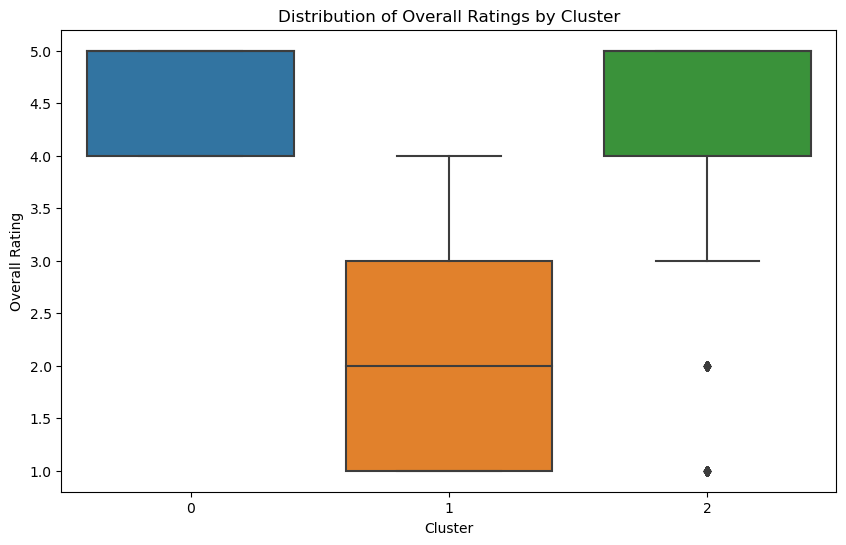

In [ ]:
# Visualize the distribution of 'overall_rating' within each cluster using box plots
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster_label', y='overall_rating', data=data)
plt.title('Distribution of Overall Ratings by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Overall Rating')

plt.show()

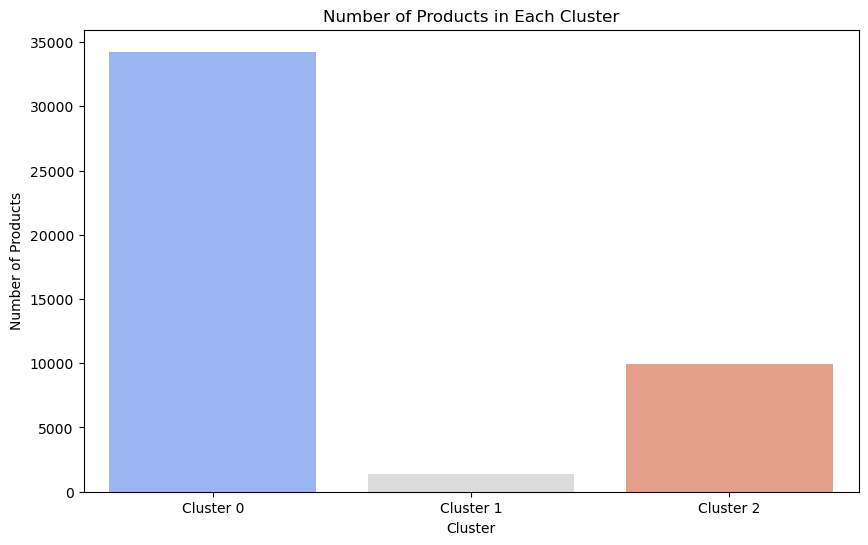

<Figure size 1000x600 with 0 Axes>

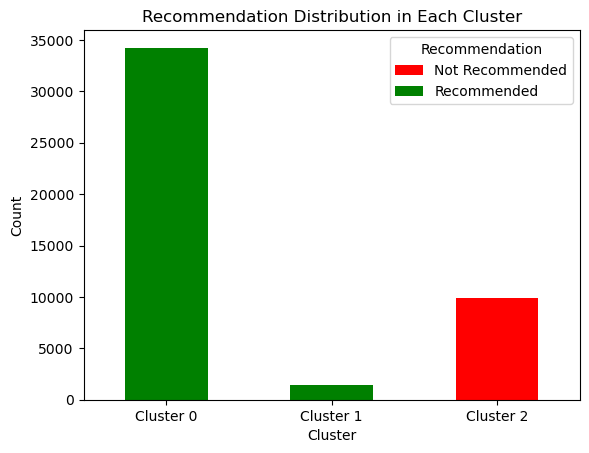

In [ ]:
# Cluster Count Bar Chart
# Count the number of products in each cluster
cluster_counts = data['cluster_label'].value_counts().sort_index()

# Plotting the cluster counts
plt.figure(figsize=(10, 6))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='coolwarm')
plt.title('Number of Products in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Products')
plt.xticks(range(len(cluster_counts.index)), labels=['Cluster ' + str(i) for i in cluster_counts.index])

plt.show()

# Recommendation Distribution
# Count the number of recommendations ('Recommended' or 'Not Recommended') in each cluster
recommendation_distribution = data.groupby(['cluster_label', 'recommendation']).size().unstack(fill_value=0)

# Plotting the recommendation distribution
plt.figure(figsize=(10, 6))
recommendation_distribution.plot(kind='bar', stacked=True, color=['red', 'green'])
plt.title('Recommendation Distribution in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.xticks(ticks=np.arange(len(recommendation_distribution.index)), labels=['Cluster ' + str(i) for i in recommendation_distribution.index], rotation=0)

plt.legend(title='Recommendation')
plt.show()

<Figure size 1200x800 with 0 Axes>

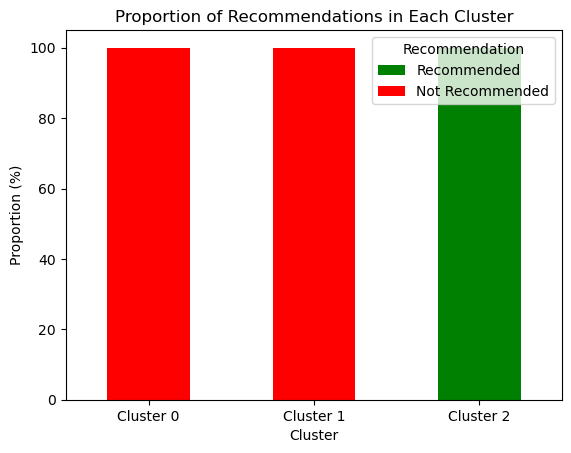

In [ ]:
# visualize the proportion of recommended products in each cluster.
# Calculate the proportion of recommendations
recommendation_proportion = data.groupby('cluster_label')['recommendation'].value_counts(normalize=True).unstack(fill_value=0) * 100

# Plotting the proportion of recommendations
plt.figure(figsize=(12, 8))
recommendation_proportion.plot(kind='bar', stacked=True, color=['green', 'red'])
plt.title('Proportion of Recommendations in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Proportion (%)')
plt.xticks(ticks=np.arange(len(recommendation_proportion.index)), labels=['Cluster ' + str(i) for i in recommendation_proportion.index], rotation=0)
plt.legend(title='Recommendation', labels=['Recommended', 'Not Recommended'])

plt.show()

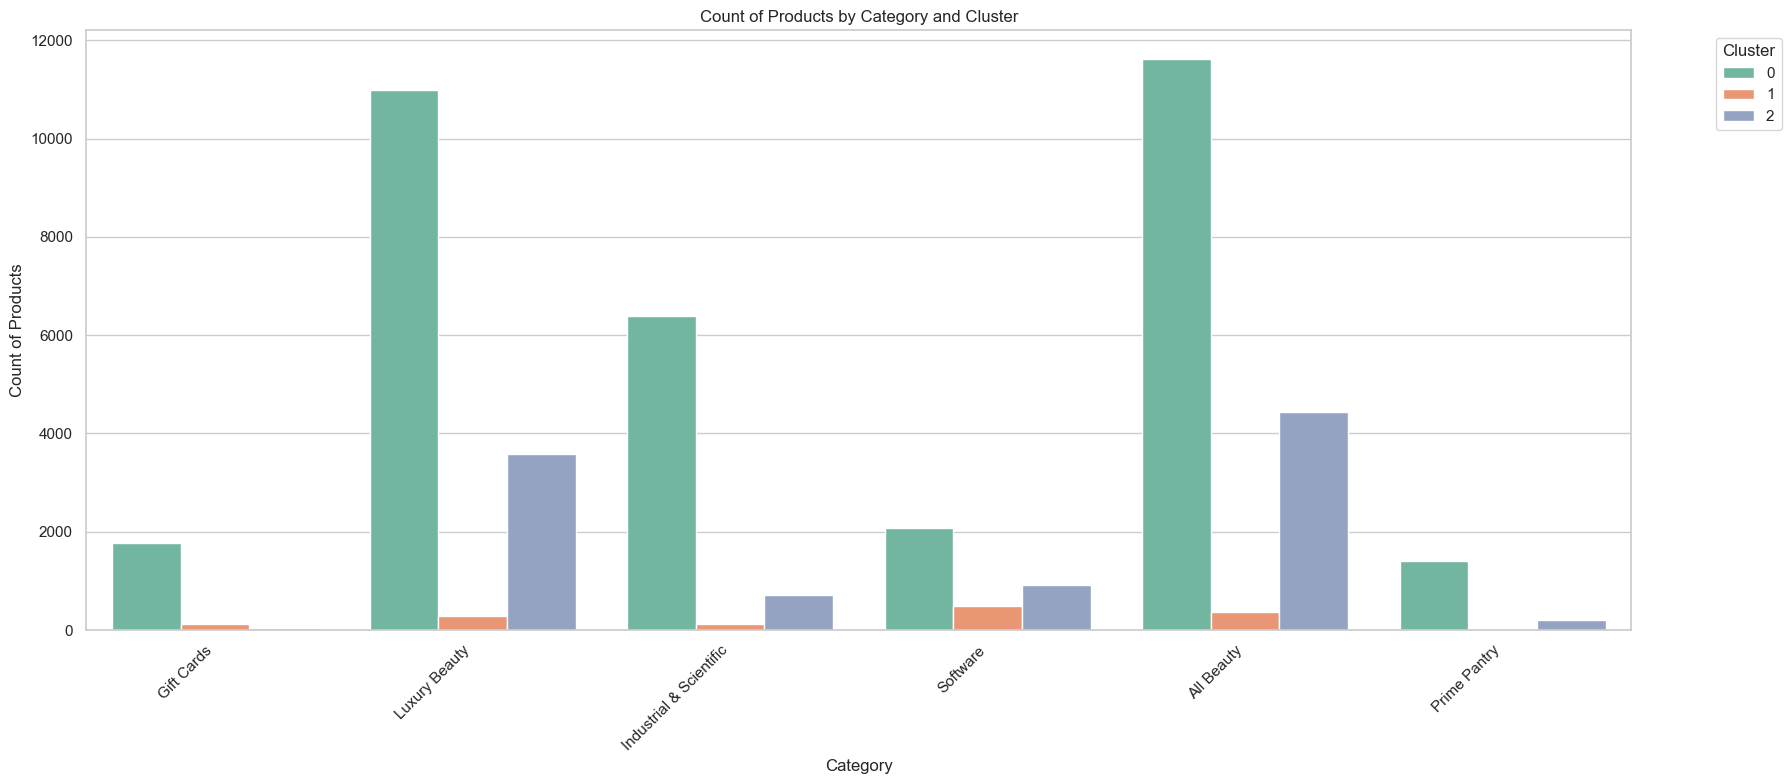

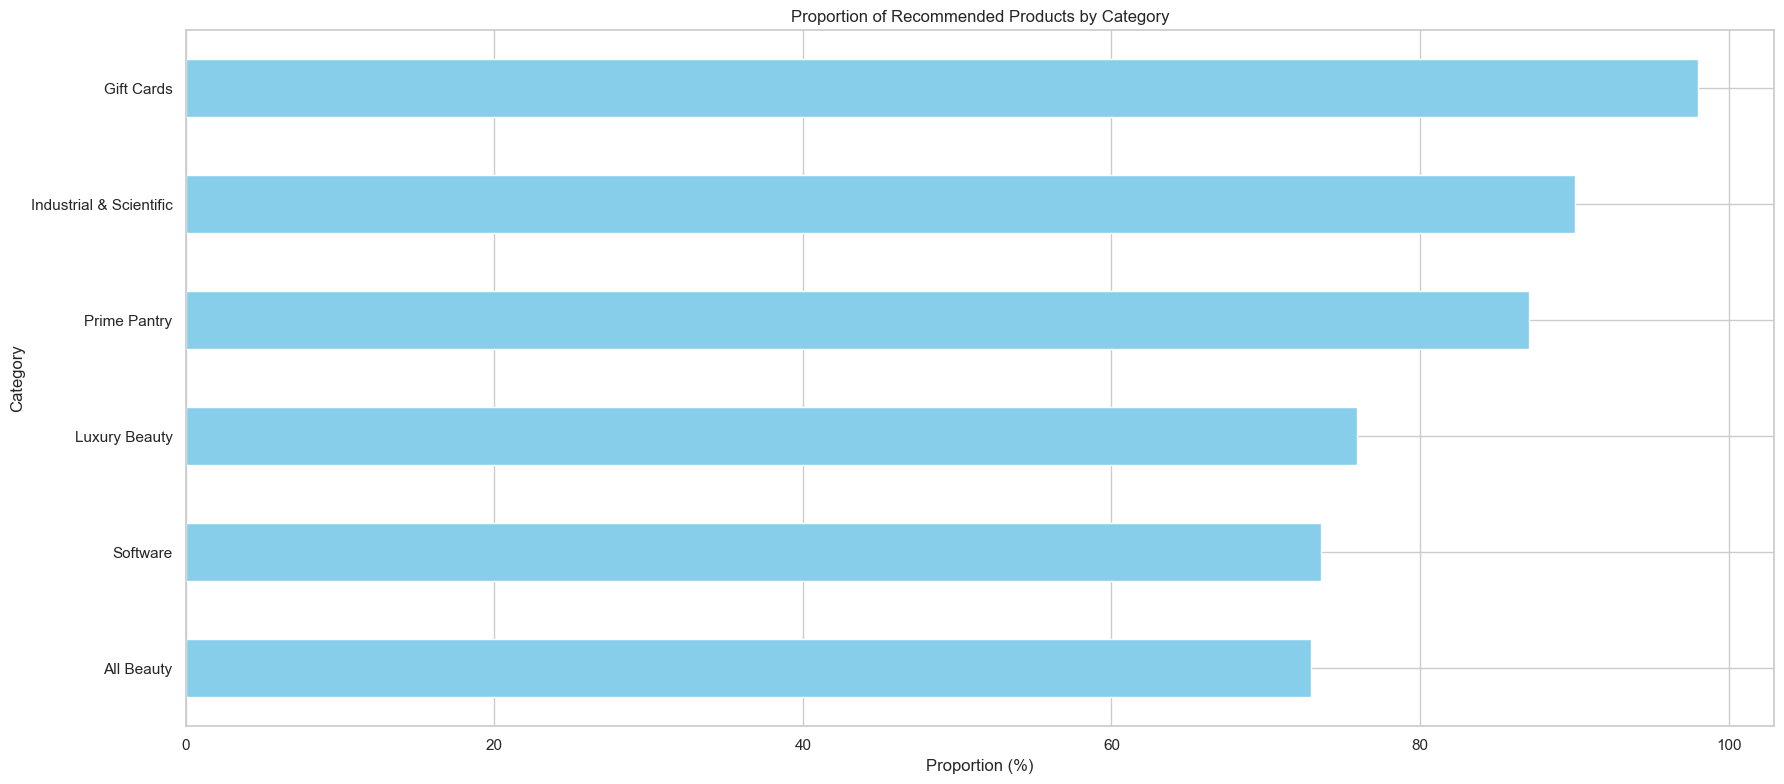

In [ ]:
# Count of Products by Category and Cluster
plt.figure(figsize=(18, 8))
sns.countplot(x='category', hue='cluster_label', data=data, palette='Set2')
plt.title('Count of Products by Category and Cluster')
plt.xlabel('Category')
plt.ylabel('Count of Products')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Proportion of Recommended Products by Category
# Calculate the proportion of recommended products within each category
category_recommendation = data.groupby('category')['recommendation'].value_counts(normalize=True).unstack(fill_value=0) * 100

# Plotting the proportion of recommended products by category
plt.figure(figsize=(18, 8))
category_recommendation['Recommended'].sort_values().plot(kind='barh', color='skyblue')
plt.title('Proportion of Recommended Products by Category')
plt.xlabel('Proportion (%)')
plt.ylabel('Category')

plt.tight_layout()
plt.show()

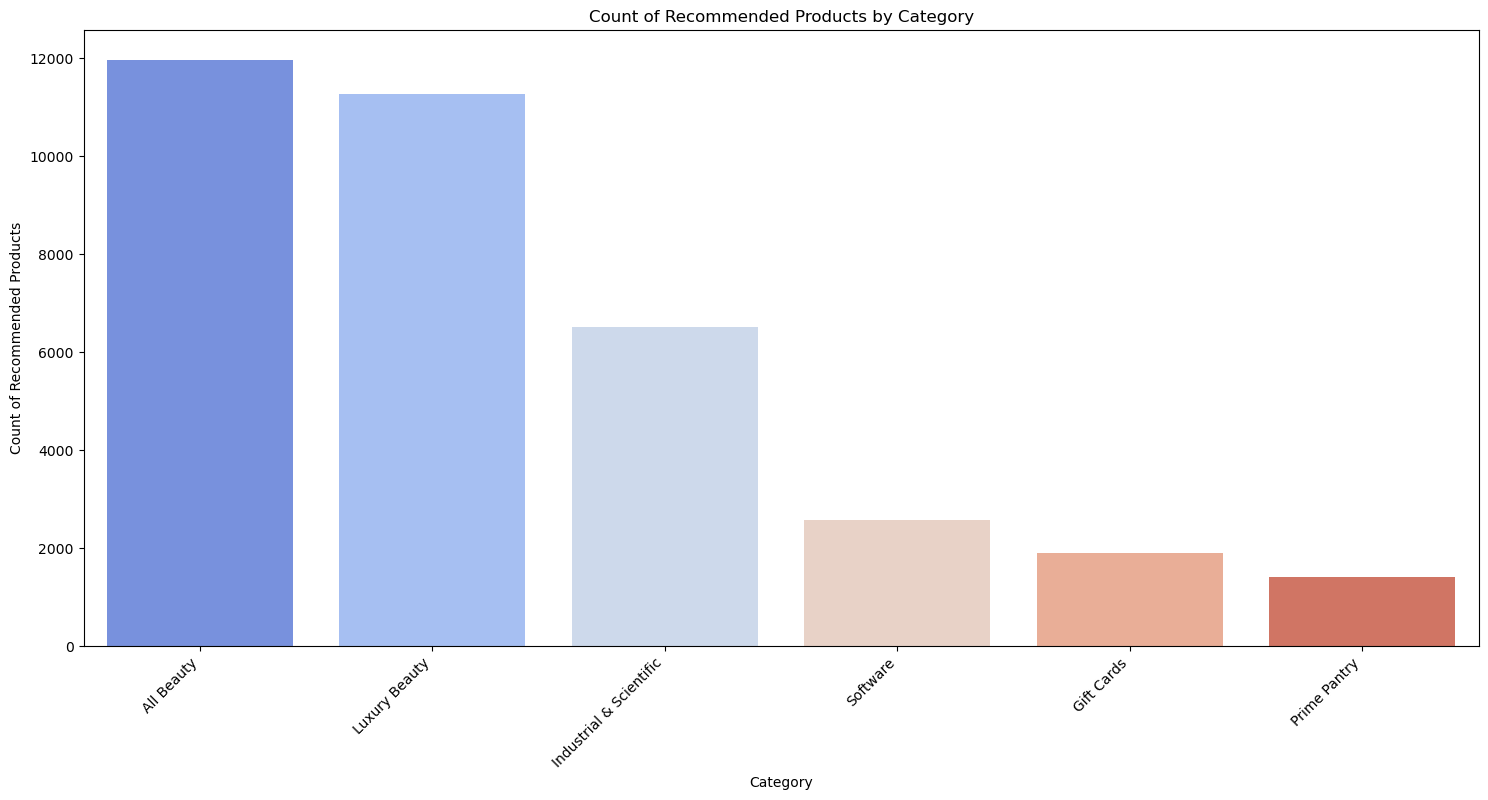

In [ ]:
# Filtering the data for only recommended products
recommended_products = data[data['recommendation'] == 'Recommended']

# Counting the number of recommended products in each category
recommended_counts = recommended_products['category'].value_counts().sort_values(ascending=False)

# Plotting the count of recommended products by category
plt.figure(figsize=(18, 8))
sns.barplot(x=recommended_counts.index, y=recommended_counts.values, palette='coolwarm')
plt.title('Count of Recommended Products by Category')
plt.xlabel('Category')
plt.ylabel('Count of Recommended Products')
plt.xticks(rotation=45, ha='right')

plt.show()

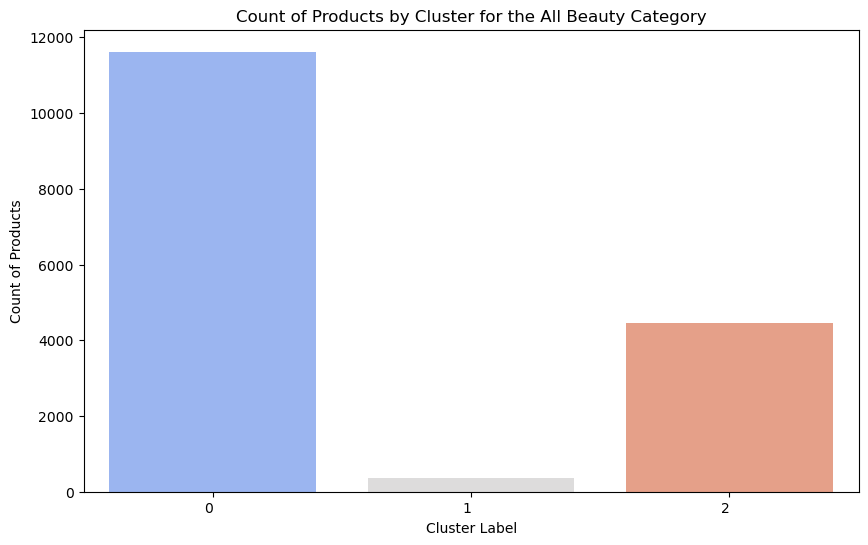

In [ ]:
# Filter for only the "All Beauty" category
AllBeauty_data = data[data['category'] == 'All Beauty']

# Counting the number of products (both recommended and not recommended) in each cluster within the "All Beauty" category
AllBeauty_cluster = AllBeauty_data['cluster_label'].value_counts().sort_values(ascending=False)

# Plotting the count of products by cluster for the "All Beauty" category
plt.figure(figsize=(10, 6))
sns.barplot(x=AllBeauty_cluster.index, y=AllBeauty_cluster.values, palette='coolwarm')
plt.title('Count of Products by Cluster for the All Beauty Category')
plt.xlabel('Cluster Label')
plt.ylabel('Count of Products')
plt.xticks(ha='right')

plt.show()

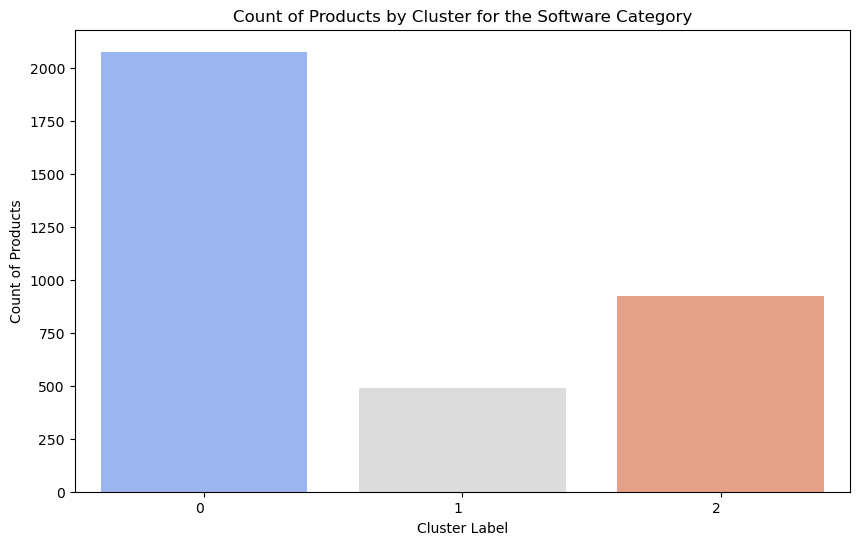

In [ ]:
# Filter for only the "All Beauty" category
Software_data = data[data['category'] == 'Software']

# Counting the number of products (both recommended and not recommended) in each cluster within the "All Beauty" category
Software_cluster = Software_data['cluster_label'].value_counts().sort_values(ascending=False)

# Plotting the count of products by cluster for the "All Beauty" category
plt.figure(figsize=(10, 6))
sns.barplot(x=Software_cluster.index, y=Software_cluster.values, palette='coolwarm')
plt.title('Count of Products by Cluster for the Software Category')
plt.xlabel('Cluster Label')
plt.ylabel('Count of Products')
plt.xticks(ha='right')

plt.show()

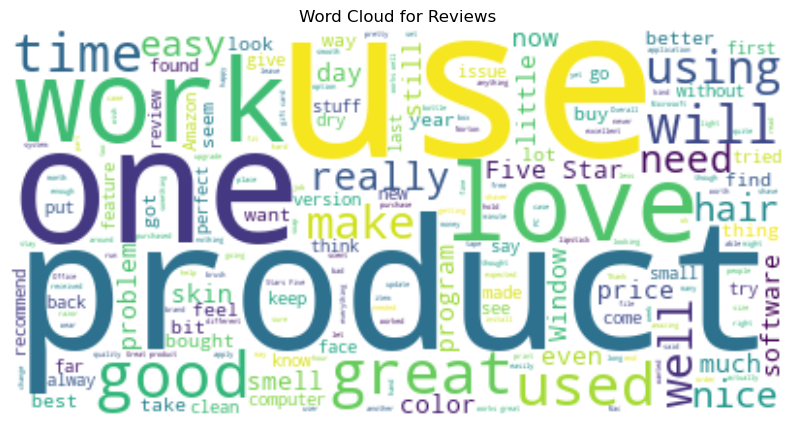

In [ ]:
from wordcloud import WordCloud

text = ' '.join(review for review in data['reviewText'].astype(str))

# Generate a word cloud image
wordcloud = WordCloud(background_color='white').generate(text)

# Display the generated image:
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Reviews')
plt.show()

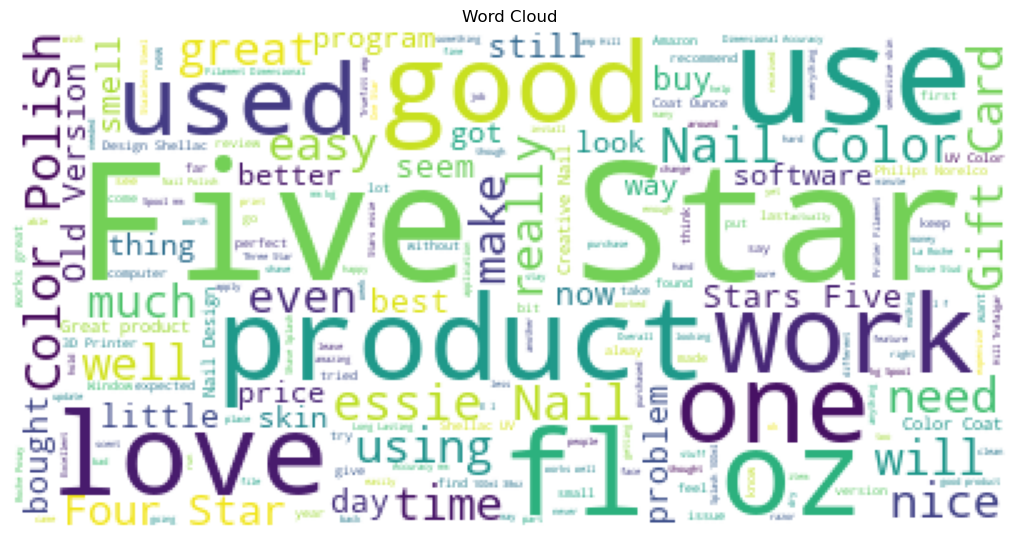

In [ ]:
combined_text = ' '.join(data['reviewText'].astype(str) + ' ' +
                         data['summary'].astype(str) + ' ' +
                         data['title'].astype(str))

# Generate a word cloud image from the combined text
wordcloud = WordCloud(background_color ='white', stopwords = None).generate(combined_text)
# Display the generated image
plt.figure(figsize=(10, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Word Cloud')
plt.tight_layout(pad=0)

plt.show()

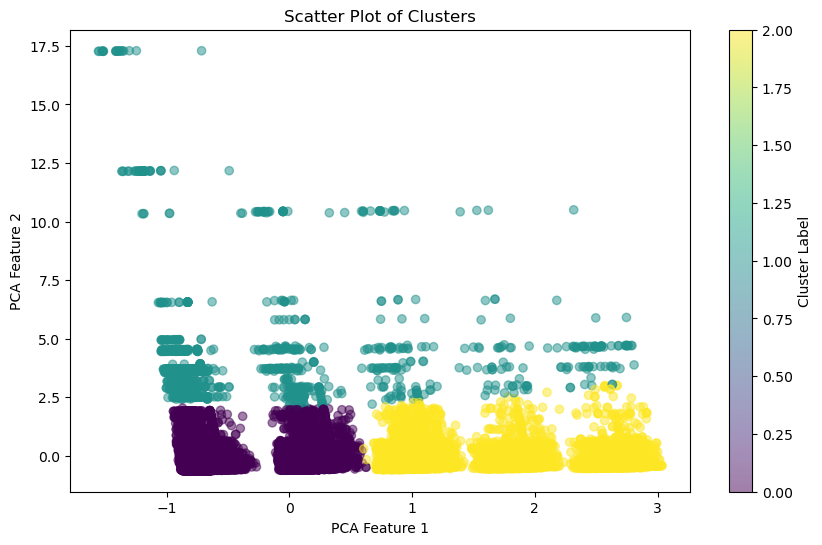

In [ ]:
import matplotlib.pyplot as plt
# Scatter plot of the PCA-reduced data with cluster labels as color
plt.figure(figsize=(10, 6))
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=data['cluster_label'], cmap='viridis', alpha=0.5)
plt.colorbar(label='Cluster Label')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.title('Scatter Plot of Clusters')
plt.show()

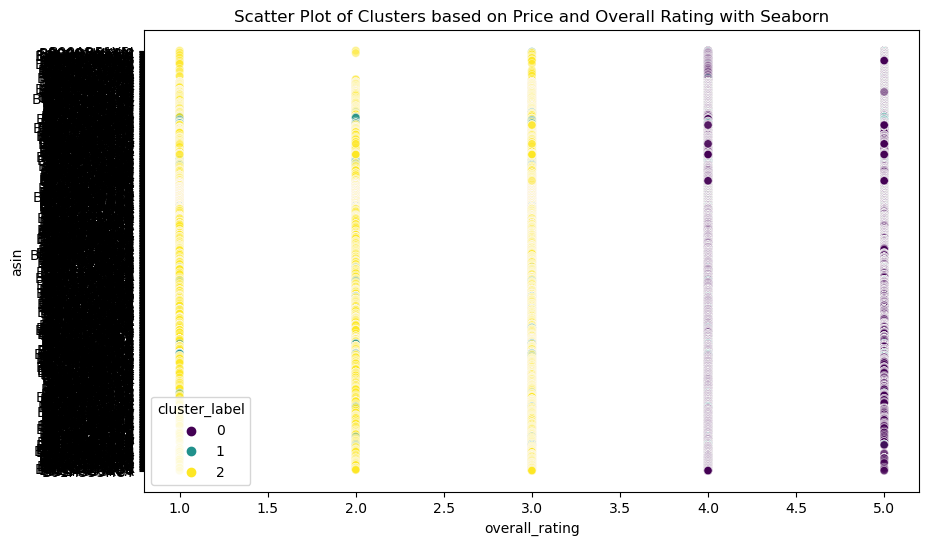

In [ ]:
import seaborn as sns
# Scatter plot with seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='overall_rating', y='asin', hue='cluster_label', palette='viridis', alpha=0.5)
plt.title('Scatter Plot of Clusters based on Price and Overall Rating with Seaborn')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


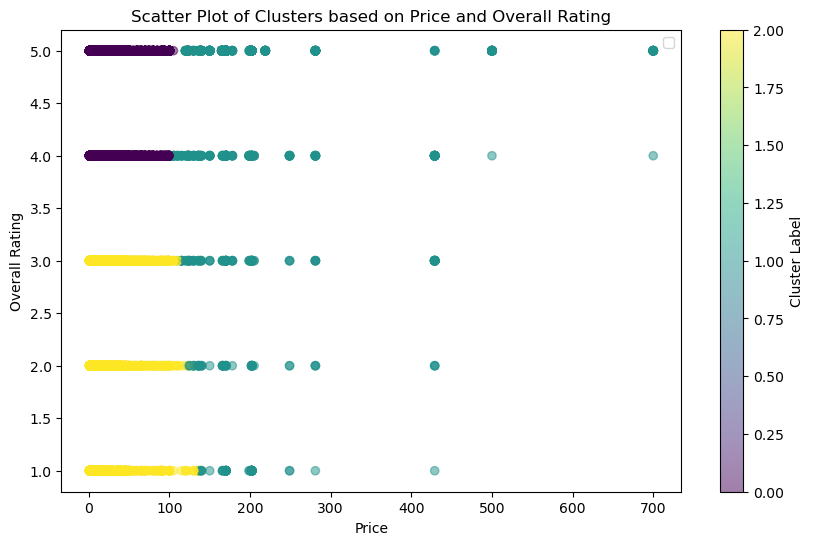

In [ ]:
# Scatter plot of the data with cluster labels as color
plt.figure(figsize=(10, 6))
plt.scatter(data['price'], data['overall_rating'], c=data['cluster_label'], cmap='viridis', alpha=0.5)
plt.colorbar(label='Cluster Label')
plt.xlabel('Price')
plt.ylabel('Overall Rating')
plt.title('Scatter Plot of Clusters based on Price and Overall Rating')
plt.legend()
plt.show()

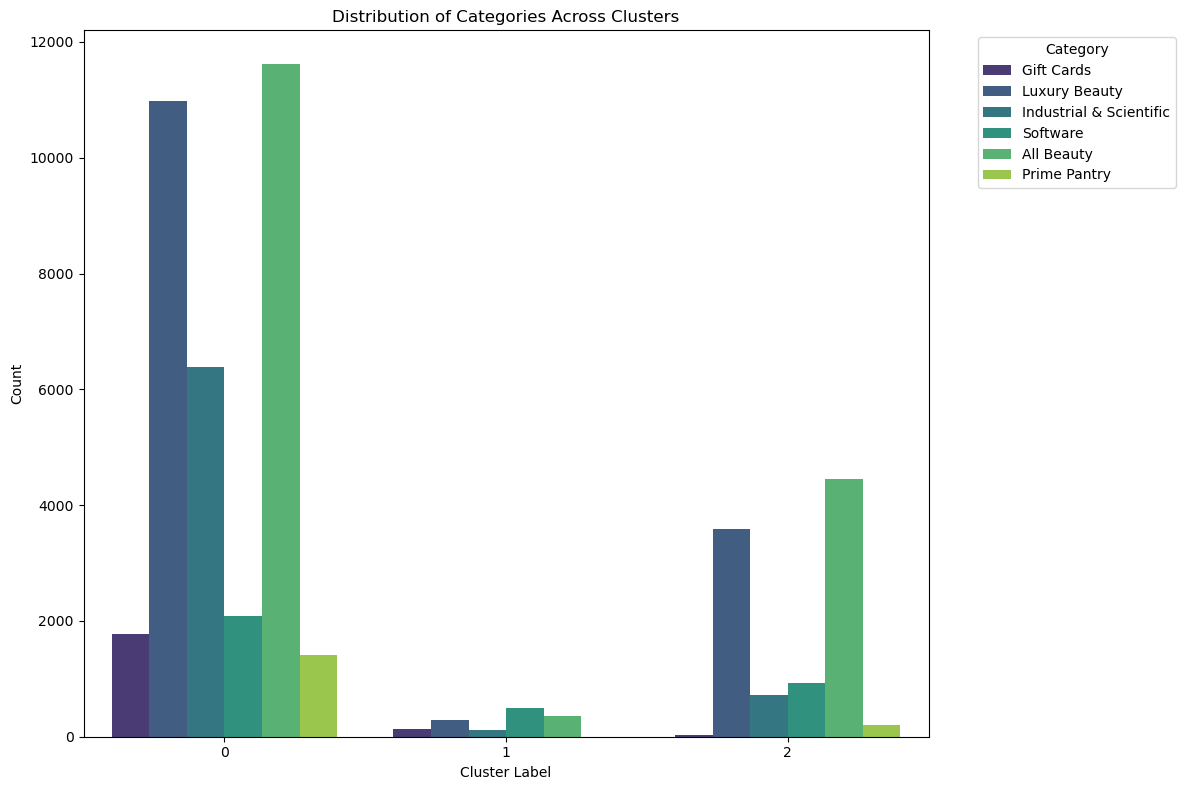

In [ ]:
plt.figure(figsize=(12, 8))
sns.countplot(data=data, x='cluster_label', hue='category', palette='viridis')
plt.title('Distribution of Categories Across Clusters')
plt.xlabel('Cluster Label')
plt.ylabel('Count')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside the plot

plt.tight_layout()
plt.show()

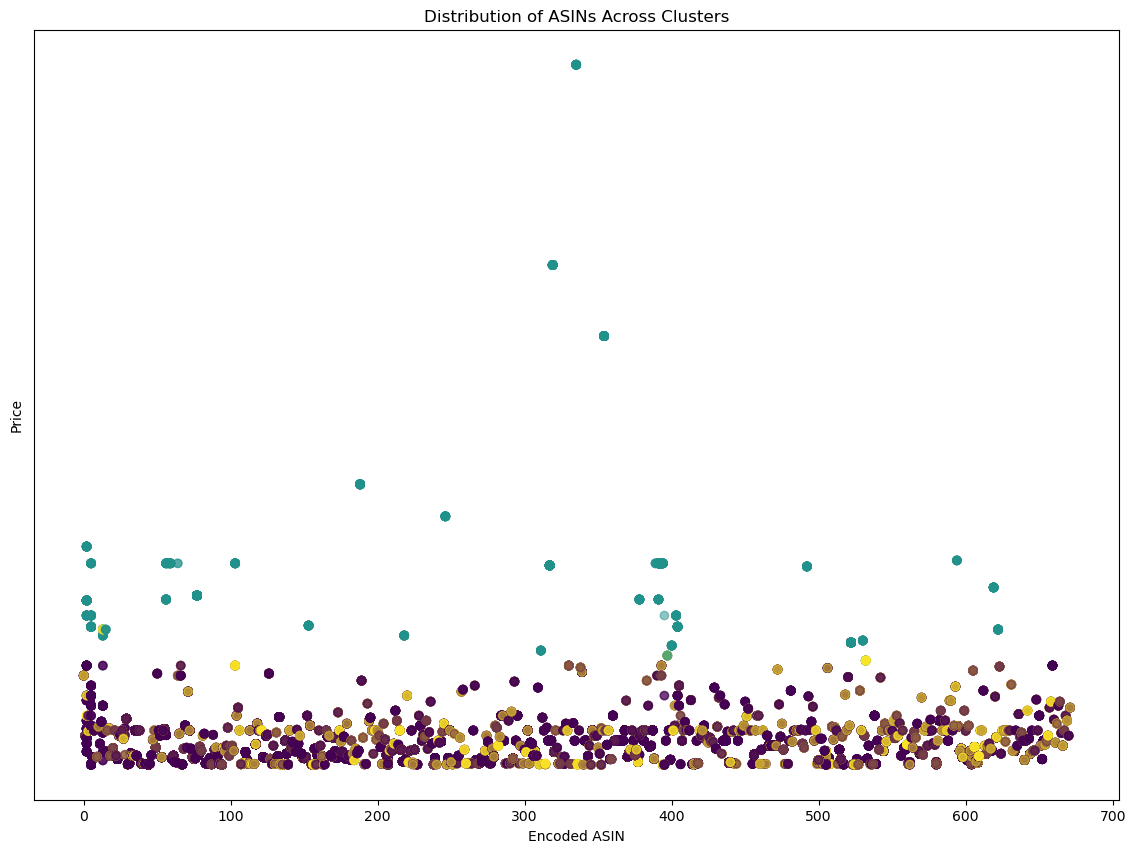

In [ ]:
# Encode ASINs as numeric values for plotting
data['ASIN_numeric'] = data['asin'].astype('category').cat.codes
y = data['price']

# Plotting
plt.figure(figsize=(14, 10))

# Create a scatter plot with colors representing different clusters
plt.scatter(data['ASIN_numeric'], data['price'], c=data['cluster_label'], cmap='viridis', alpha=0.5)

plt.ylabel('Price')
plt.xlabel('Encoded ASIN')
plt.title('Distribution of ASINs Across Clusters')
plt.yticks([])

plt.show()


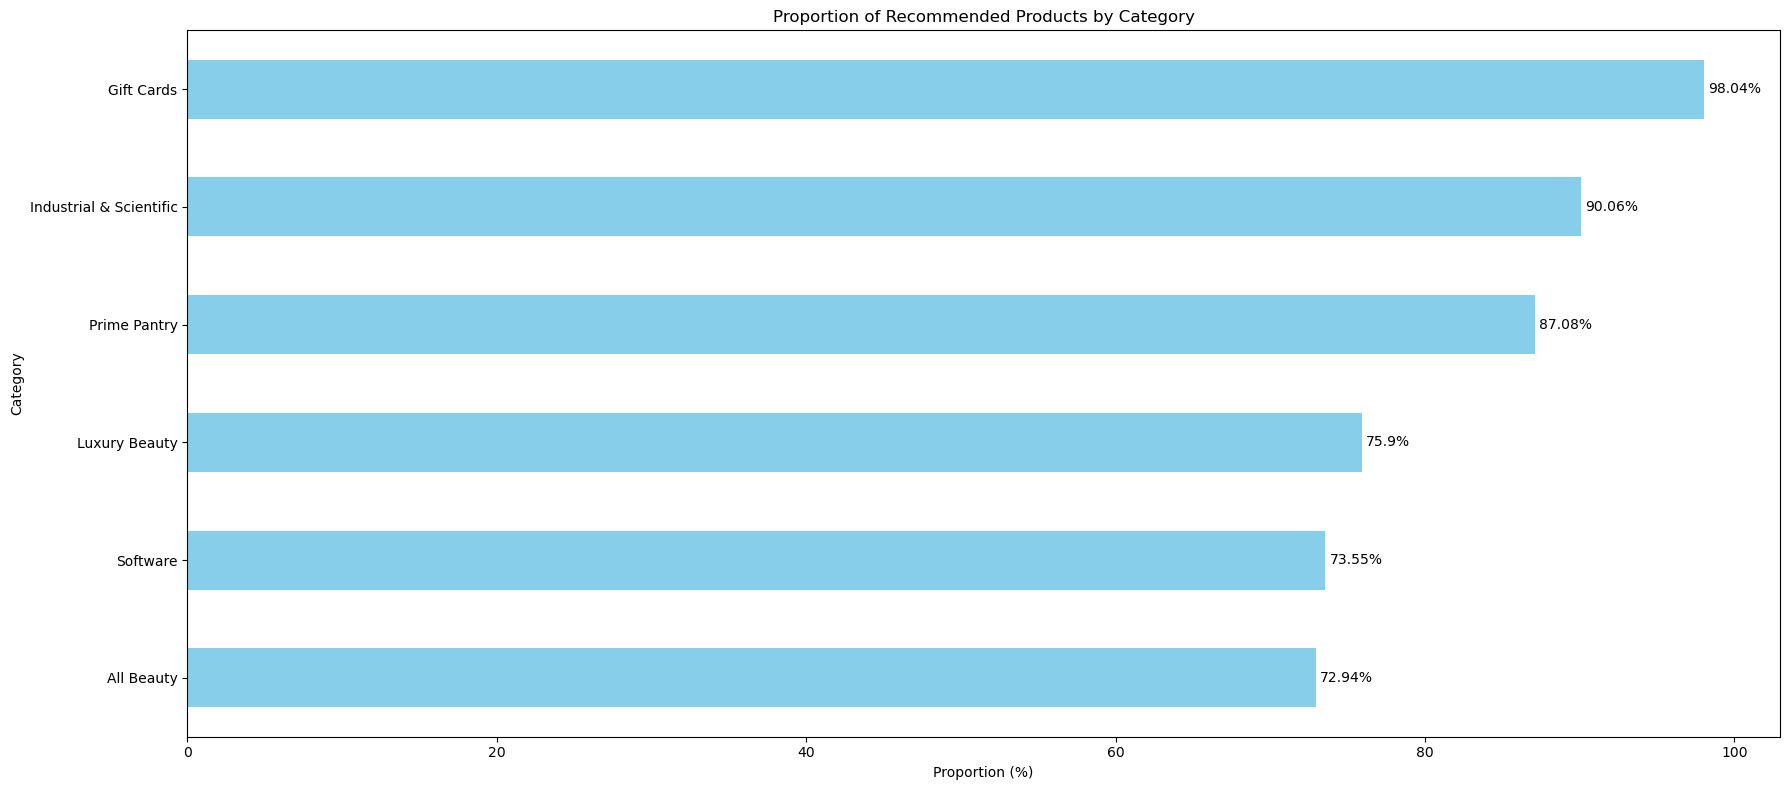

In [ ]:
plt.figure(figsize=(18, 8))
bars = category_recommendation['Recommended'].sort_values().plot(kind='barh', color='skyblue')
plt.title('Proportion of Recommended Products by Category')
plt.xlabel('Proportion (%)')
plt.ylabel('Category')

# Annotating the bars
for bar in bars.containers[0]:
    plt.gca().annotate(f"{round(bar.get_width(), 2)}%", xy=(bar.get_width(), bar.get_y() + bar.get_height()/2),
                xytext=(3, 0), textcoords="offset points", ha='left', va='center')

plt.tight_layout()
plt.show()

ValueError: cannot convert float NaN to integer

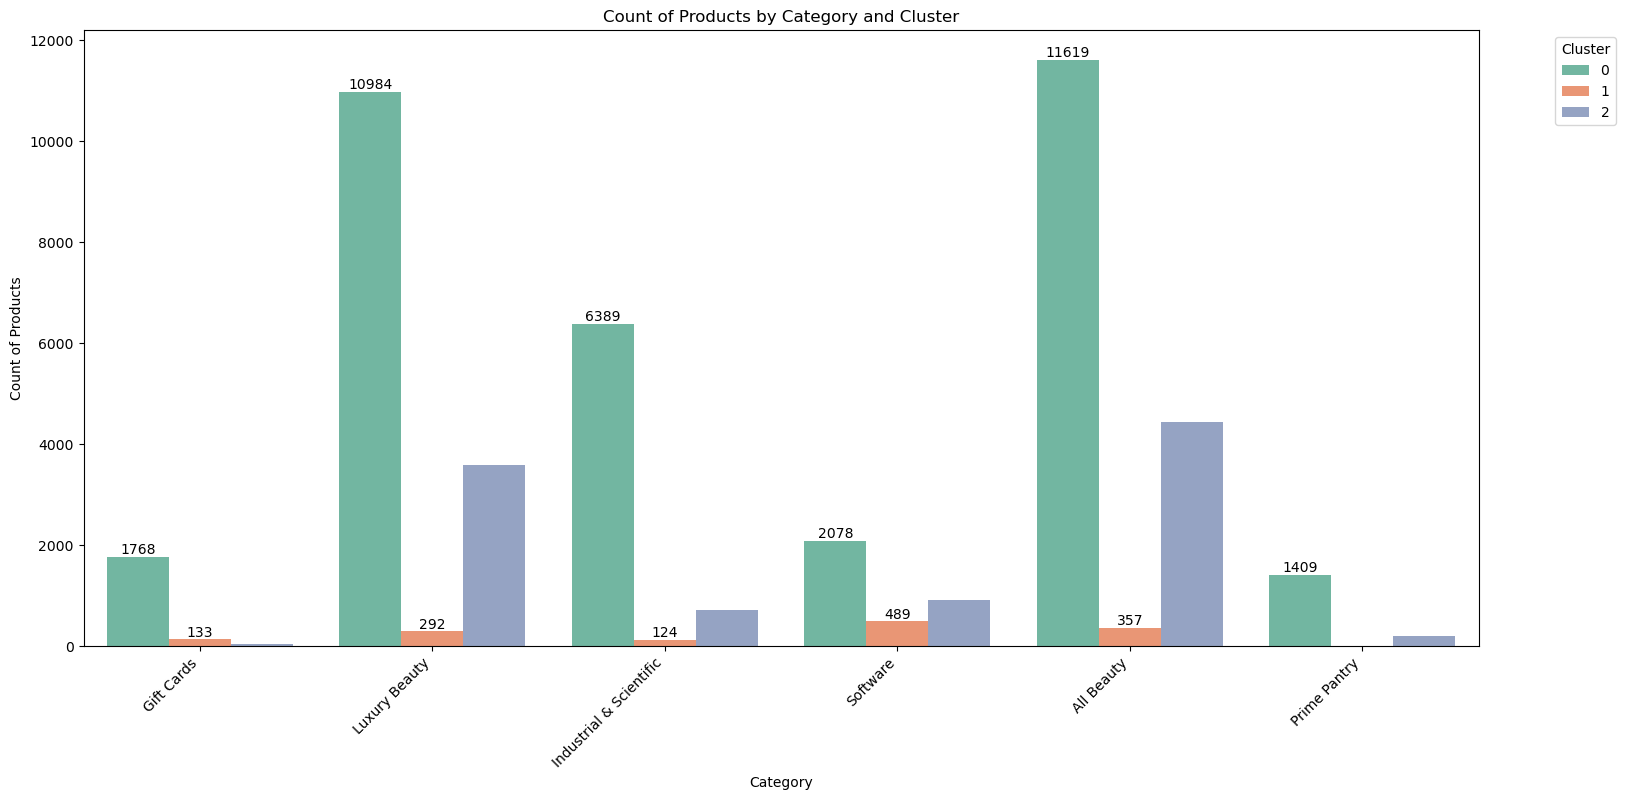

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 8))
ax = sns.countplot(x='category', hue='cluster_label', data=data, palette='Set2')
plt.title('Count of Products by Category and Cluster')
plt.xlabel('Category')
plt.ylabel('Count of Products')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

# Annotating the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.tight_layout()
plt.show()

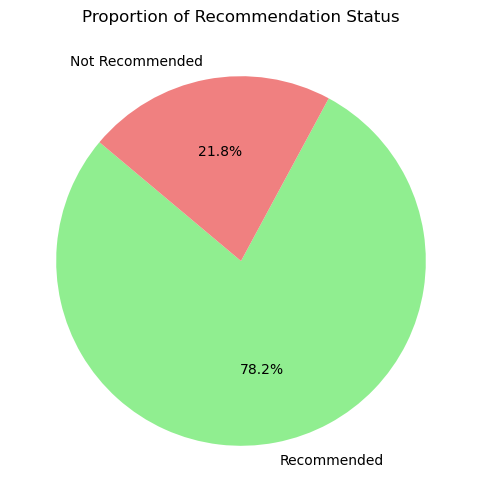

In [ ]:
#Count the occurrences of each recommendation status
recommendation_counts = data['recommendation'].value_counts()

# Plotting
plt.figure(figsize=(8, 6))
recommendation_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=['lightgreen', 'lightcoral'])
plt.title('Proportion of Recommendation Status')
plt.ylabel('')  # Hide the y-label as it's not needed for a pie chart

plt.show()

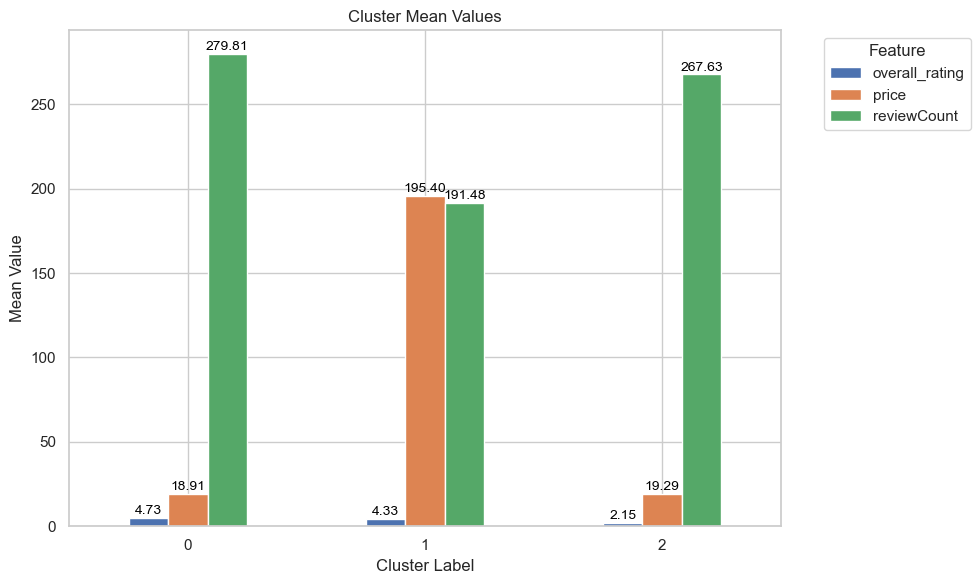

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Calculate mean values for each cluster
cluster_means = data.groupby('cluster_label').mean()[['overall_rating', 'price', 'reviewCount']]

# Plotting with capturing the axis (ax)
fig, ax = plt.subplots(figsize=(10, 6))
cluster_means.plot(kind='bar', ax=ax)
plt.title('Cluster Mean Values')
plt.xlabel('Cluster Label')
plt.ylabel('Mean Value')
plt.xticks(rotation=0)
plt.legend(title='Feature', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Annotating the bars with a check for NaN values and displaying as integer or float
for p in ax.patches:
    height = p.get_height()
    if pd.notnull(height):  # Check if height is not NaN
        # Display as integer if the decimal part is 0; otherwise, display as float
        label = f'{int(height)}' if height.is_integer() else f'{height:.2f}'
        ax.annotate(label, (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')
    else:
        print(f"Skipping annotation for NaN value at {p.get_x()}")

# Show plot
plt.show()

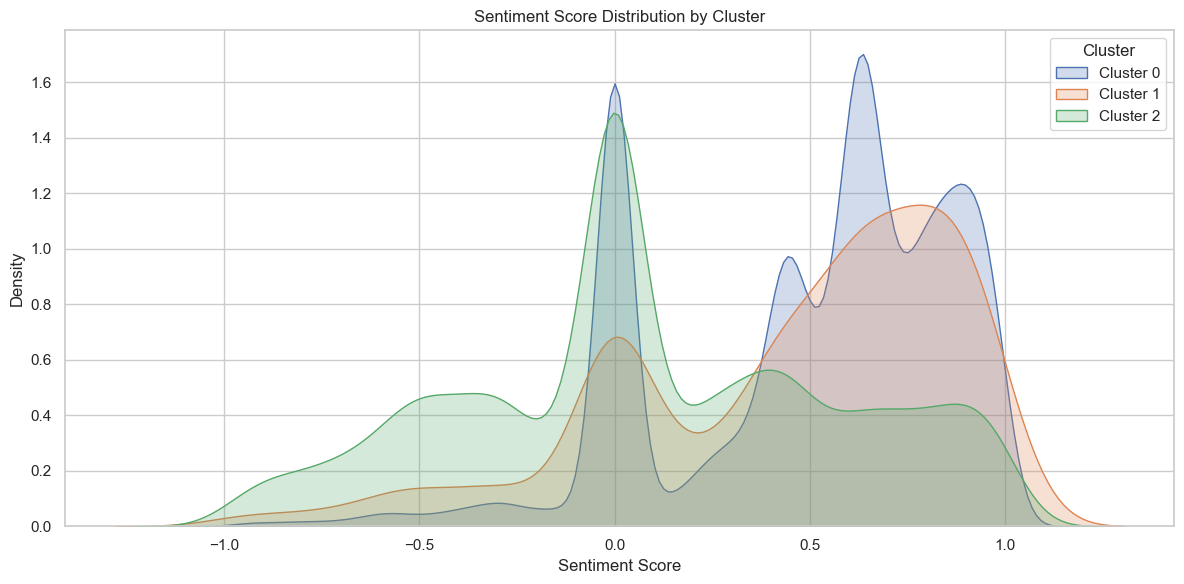

In [ ]:
# Plotting the Sentiment Score Distribution for each cluster
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# Plotting density plots for each cluster
for cluster in sorted(data['cluster_label'].unique()):
    sns.kdeplot(data[data['cluster_label'] == cluster]['reviewText_sentiment'], label=f'Cluster {cluster}', shade=True)

plt.title('Sentiment Score Distribution by Cluster')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.legend(title='Cluster')
plt.tight_layout()

# Show plot
plt.show()

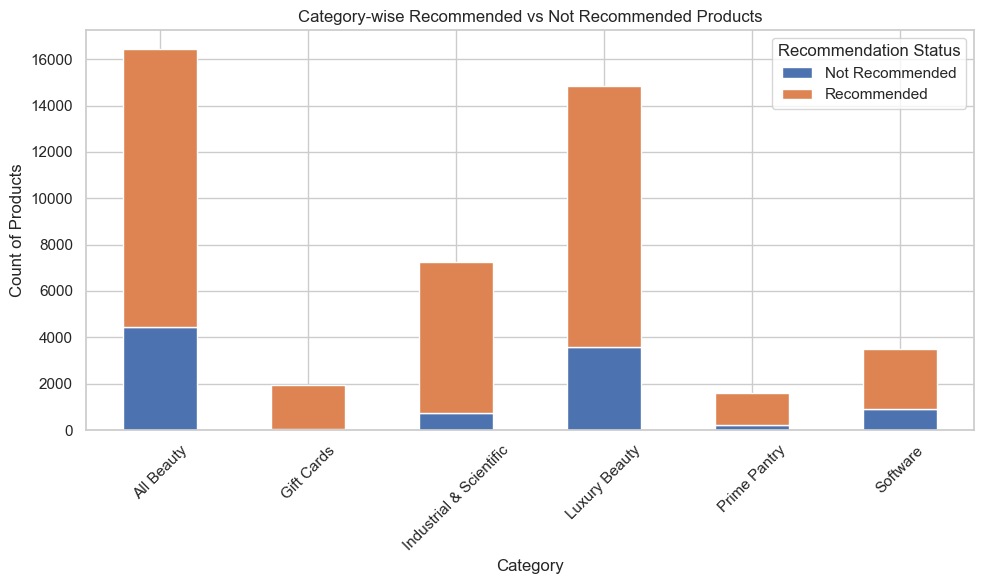

In [ ]:
# Counting the number of recommended and not recommended products by category
recommendation_count = data.groupby(['category', 'recommendation']).size().unstack(fill_value=0)

# Plotting
recommendation_count.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.title('Category-wise Recommended vs Not Recommended Products')
plt.xlabel('Category')
plt.ylabel('Count of Products')
plt.xticks(rotation=45)
plt.legend(title='Recommendation Status')

plt.tight_layout()
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ea42f488-32e8-4a8d-9e6d-e3bf40f3e1bb' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>